In [5]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
import os

Nchunk = 20
trials = 1e4
folder = '/home/ambra/Desktop/cluster-morgana/archive_tests/run0406_10000x/' 
os.system('mkdir %spng' %folder)
path = folder + 'run0406/run0406_ID000126/csv/'

texp = [1,5,10,100]
sigma = [5]
chunk = [i+1 for i in range(Nchunk)]
chunk = [2,3,4,5,6,7,10,11,15,17,18,19]

csvName = [[]*i for i in range(len(texp))]
for i in range(len(chunk)) :  
    for j in range(len(texp)) :
        csvName[j].append('run0406_v07_%ds_chunk%02d.csv' % (texp[j], chunk[i]))
        
# merge files ---!
csvMerged= []
for j in range(len(texp)) :
    csvMerged.append('run0406_%ds.csv' %texp[j])

    fout = open(path+csvMerged[j],'w+')
    # first file ---!
    for line in open(path+csvName[j][0]):
        fout.write(line)
    # remaining files ---!    
    for i in range(len(chunk)-1):
        f = open(path+csvName[j][i+1])
        next(f) # skip the header ---!
        for line in f:
             fout.write(line)
        f.close() 
    fout.close()
    
print(csvMerged)

#for f in csvMerged:
#    with open(path+f, 'r') as inp, open(path+f.replace('.csv', '_mod.csv'), 'w') as out:
#        writer = csv.writer(out)
#        for row in csv.reader(inp):
#            if len(row) == 6 and ('ID' in row[0] or '#' in row[0]):
#                writer.writerow(row)


#for index, f in enumerate(csvMerged):
#    csvMerged[index] = f.replace('.csv', '_mod.csv')
#print(csvMerged)

# data params ---!
threshold = 0.5
ts_threshold = 25
xlim=0.2
texp=[1,5,10,100]
# initialize SphDistance calc ---!
trueRA = 33.057
trueDEC = -51.841
true_coord = SkyCoord(ra = trueRA*u.deg, dec = trueDEC*u.deg, frame='fk5')
# conf intervals params ---!
nstd = [1,2,3,5]
conf_probs = [0.6827, 0.9545, 0.9973, 0.99994]
# img params ---!
fontsize=12
CI_colors = ['k', 'r', 'g', 'w']

['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']


In [9]:
# =============================
# !!! ALL STATISTICAL PLOTS !!!
# =============================

import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('/home/ambra/Desktop/cluster-morgana/')
from module_statistics import *

cdvMerged = ['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']

png_path = folder + 'png/'
# hist params ---!
Dwidth = 0.02
Dnbin = int(threshold / Dwidth)

list_ra, list_dec, list_pos = ([[] for i in range(len(texp))] for j in range(3))
list_modes, list_mean_ra, list_mean_dec, list_mean_pos = ([[] for i in range(len(texp))] for j in range(4))
list_std_ra, list_std_dec = ([[] for i in range(len(texp))] for j in range(2))
for n in range(len(texp)) :  
    # store values ---!
    filename = csvMerged[n]
    print('\n================ texp = %ds ==============\n' %texp[n])

    # load DataFrame and column names ---!
    df = pd.read_csv(path+filename)
    cols = list(df.columns)
    trials = len(df[cols[0]])
    print('* verify trials = ', trials)  
    # drop duplicates ---! 
    df.sort_values(cols[0], inplace = True) 
    # dropping ALL duplicte values 
    df.drop_duplicates(subset=cols[0], keep='last', inplace=True) 
    trials = len(df[cols[0]])
    print('* drop duplicate => trials = ', trials) 
    total = trials
    # drop NaN ---!
    df = df.dropna()
    trials = len(df[cols[0]])
    df = df.reindex(np.arange(trials))
    print('* drop nan => trials = ', trials)  
    # set arrays ---!
    # 0      1     2      3     4     5       6        7       8        9        10/-1  
    # trial, texp, sigma, Ndet, Nsrc, RA_det, DEC_det, RA_fit, DEC_fit, flux_ph, TS
    ts = np.array(df[cols[-1]]) 
    trials = len(ts)
    df = df.reindex(np.arange(trials))
    perc = 100 * (trials/total)
    print('! NaN DETECTION RATE :', 100-perc, '%')

    for i, val in enumerate(ts):
        if val < ts_threshold:
            df = df.drop([i])

    trial = np.array(df[cols[0]])
    raDet = np.array(df[cols[5]])
    decDet = np.array(df[cols[6]])
    raFit = np.array(df[cols[7]])
    decFit = np.array(df[cols[8]])
    flux = np.array(df[cols[9]])
    ts = np.array(df[cols[-1]])

    trials = len(df[cols[0]])
    df = df.reindex(np.arange(trials))
    print('* drop TS<25 => trials = ', trials)  

    perc = 100 * (trials/total)
    print('! DETECTION RATE :', perc, '%')

    # DETECTION ---!
    distance_det = []
    d_det = []
    ra_det = []
    dec_det = []
    flux_det = []

    for i in range(len(raDet)) :
        if -90 <= decDet[i] and decDet[i] <= 90 and 0 <= raDet[i] and raDet[i] <= 360 :
            det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
            dist = float(true_coord.separation(det_coord).deg)
            distance_det.append(dist)                  

            if dist < threshold :
                d_det.append(dist)
                ra_det.append(raDet[i]) 
                dec_det.append(decDet[i]) 
                flux_det.append(flux[i])

    perc_det = len(d_det)/total * 100
    print('! DET RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_det, '%')

    # MEAN DET ---!
    mean_raDet = np.nanmean(ra_det)
    std_raDet = np.nanstd(ra_det)
    mean_decDet = np.nanmean(dec_det)
    std_decDet = np.nanstd(dec_det)
    mean_posDet = np.nanmean(d_det)
    mean_flux = np.nanmean(flux_det)
    std_flux = np.nanstd(flux_det)

    tmp = 0
    for i in range(len(d_det)) :
        tmp += d_det[i]**2

    if len(d_det) != 0.0 :
        mode_det = np.sqrt(1/(2*len(d_det)) * tmp)   
        MLE_det = 0.606/mode_det
    else:
        mode_det = np.nan
        MLE_det = np.nan

    print('~ ra det mean:', mean_raDet, 'ra det std:', std_raDet)
    print('~ dec det mean:', mean_decDet, 'dec det std:', std_decDet)
    print('~ pos det mean:', mean_posDet, 'pos det gamma:', mode_det)

    # MAX LIKELIHOOD ---!
    distance_fit = []
    d_fit = []
    ra_fit = []
    dec_fit = []

    for i in range(len(raFit)) :
        if -90 <= decFit[i] and decFit[i] <= 90 and 0 <= raFit[i] and raFit[i] <= 360 :
            fit_coord = SkyCoord(ra = raFit[i]*u.deg, dec = decFit[i]*u.deg, frame='fk5')
            dist = float(true_coord.separation(fit_coord).deg)
            distance_fit.append(dist)                  
    
            if dist < threshold and ts[i] > threshold:
                d_fit.append(dist)
                ra_fit.append(raFit[i]) 
                dec_fit.append(decFit[i]) 
            
    perc_fit = len(d_fit)/trials * 100
    print('! FIT RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_fit)
    
    # MEAN FIT ---!
    mean_raFit = np.nanmean(ra_fit)
    std_raFit = np.nanstd(ra_fit)
    mean_decFit = np.nanmean(dec_fit)
    std_decFit = np.nanstd(dec_fit)
    mean_fit = np.nanmean(d_fit)
    std_fit = np.nanstd(d_fit)
    
    print('~ ra fit mean:', mean_raFit, 'ra fit std:', std_raFit)
    print('~ dec fit mean:', mean_decFit, 'dec fit std:', std_decFit)
    print('~ pos fit mean:', mean_fit, 'pos fit std:', std_fit)
    
    tmp = 0
    for i in range(len(d_fit)) :
        tmp += d_fit[i]**2
        
    if len(d_fit) != 0.0 :
        mode_fit = np.sqrt(1/(2*len(d_fit)) * tmp)   
        MLE_fit = 0.606/mode_fit
    else:
        mode_fit = np.nan
        MLE_fit = np.nan



================ texp = 1s ==============

* verify trials =  9650
* drop duplicate => trials =  8050
* drop nan => trials =  6439
! NaN DETECTION RATE : 20.01242236024845 %
* drop TS<25 => trials =  5172
! DETECTION RATE : 64.24844720496894 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 40.45962732919255 %
~ ra det mean: 33.05780096861623 ra det std: 0.05574155237785954
~ dec det mean: -51.839998588957414 dec det std: 0.03232442277285471
~ pos det mean: 0.04097742153091761 pos det gamma: 0.03340813599886214
! FIT RATIO WITHIN 0.5deg FROM TRUE POSITION: 62.97370456303171
~ ra fit mean: 33.05740272161176 ra fit std: 0.04723139952040572
~ dec fit mean: -51.84067023717926 dec fit std: 0.02807054350610322
~ pos fit mean: 0.03514950312568093 pos fit std: 0.02010522752152445

================ texp = 5s ==============

* verify trials =  9650
* drop duplicate => trials =  8050
* drop nan => trials =  8047
! NaN DETECTION RATE : 0.037267080745337466 %
* drop TS<25 => trials =  8047
! DETECTI

In [ ]:
# ------------------------------------------ plots ---!
c = ['darkgreen', 'red', 'navy', 'gold']
l_ra = ['texp=%ds, $\sigma$=%.3f' %(texp[i], list_std_ra[i][0]) for i in range(len(texp))]
l_dec = ['texp=%ds, $\sigma$=%.3f' %(texp[i], list_std_dec[i][0]) for i in range(len(texp))]
l_pos = ['texp=%ds, $\gamma$=%.3f' %(texp[i], list_modes[i][0]) for i in range(len(texp))]
alpha = 0.1
    
# DETECTION 1D ---!
fig, ax = hist1d_gauss(list_ra, mean=None, loc=trueRA, threshold=threshold, nbin=Dnbin, width=Dwidth,
                       fontsize=fontsize, color=c, alpha=alpha, hist=False,
                       title='detected RA distribution', leglabel=l_ra,
                       xlabel='RA (deg)', ylabel='counts density',
                       filename=png_path+'run0406_detRA.png')   
plt.show()
plt.close()

fig, ax = hist1d_gauss(list_dec, mean=None, loc=trueDEC, nbin=Dnbin, width=Dwidth,
                       threshold=threshold, fontsize=fontsize, color=c, alpha=alpha,
                       title='detected DEC distribution', leglabel=l_dec, hist=False, 
                       xlabel='DEC (deg)', ylabel='counts density',
                       filename=png_path+'run0406_detDEC.png') 
plt.show()
plt.close()

fig, ax = hist1d_rayleigh(list_pos, mean=None, rayleigh_prms={'loc':0, 'scale':None}, 
                          threshold=threshold, nbin=Dnbin, width=Dwidth, fontsize=fontsize, 
                          color=c, alpha=alpha, leglabel=l_pos, hist=False,
                          title='detected $\\Delta \\Theta$ distribution',
                          xlabel='$\\Delta \\Theta$ (deg)', ylabel='counts density',
                          filename=png_path+'run0406_detPOS.png')
plt.show()
plt.close()


    
    
    
print('\n\nok')


In [ ]:
# KDE SIZE = SKYMAP PIXEL-SIZE

# library & dataset
import seaborn as sns
 
# Basic 2D density plot
sns.set_style("white")
sns.kdeplot(ra_det, dec_det, n_levels=5, bw=Dwidth, cbar=True, color='red')
plt.show()

# Custom it with the same argument as 1D density plot
sns.kdeplot(ra_det, dec_det, n_levels=100, cmap="jet", shade=True, bw=Dwidth, cbar=True)
plt.show()

# Some features are characteristic of 2D: color palette and wether or not color the lowest range
sns.kdeplot(ra_det, dec_det, cmap="Blues", shade=True, shade_lowest=True, bw=Dwidth, cbar=True)
plt.show()

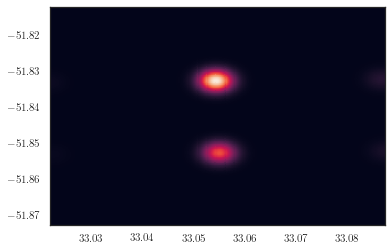

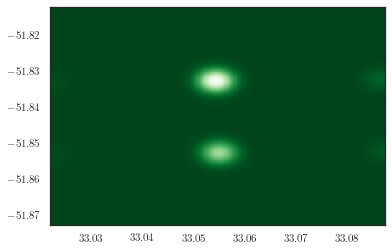

In [8]:
# ESTIMATE KDE FROM DATA

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
# create data
x = np.array(ra_det)
y = np.array(dec_det)
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()
 
# Change color palette
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
plt.show()
